## Imports

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer, wordpunct_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

In [16]:
# Define dataframe path
df_path = "../data/final_dataset.csv"

In [17]:
# load data
df = pd.read_csv(df_path).drop(columns="Unnamed: 0")

# Get some basic information 
print(f"Sample Data :{df.head()}")
print(f"\n--------------------------\n\n Columns : {[i for i in df.columns]}")
print(f"\n--------------------------\n\n Size of the dataset : {df.shape[0]}")
print(f"\n--------------------------\n\n Total number of columns : {df.shape[1]}")

Sample Data :            author                                        description  \
0          TuaAnon  yes, it's an lte watch with data turned on, no...   
1  DemandScary1934  how accurate is the active/total calorie track...   
2         Vinumite  fell very hard blackout drunk and lost watch. ...   
3          Damarou  pls tell me i‘m not the only one who has such ...   
4       ThorNike13  deleted apps in watch app on iphone with weird...   

    subreddit  des_word_count  
0  AppleWatch              48  
1  AppleWatch              10  
2  AppleWatch              59  
3  AppleWatch              15  
4  AppleWatch              15  

--------------------------

 Columns : ['author', 'description', 'subreddit', 'des_word_count']

--------------------------

 Size of the dataset : 5270

--------------------------

 Total number of columns : 4


In [18]:
# Drop unusefull columns
df.drop(columns =["author", "des_word_count"], inplace=True)

In [19]:
# Create label column (target column)
df["subreddit"] = df["subreddit"].map({"GalaxyWatch": 1, "AppleWatch":0})

## Functions

In [21]:
# Cite: Got help form Katie Sylvia
# Function for stemming
def stem_words(text):
    # Initialize the Porter stemmer
    stemmer = PorterStemmer()
    
    # Tokenize the text into individual words
    words = nltk.word_tokenize(text)
    
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    stemmed_text = " ".join(stemmed_words)
    
    return stemmed_text

In [32]:
# Grid search over with pipeline estimator
def gridsearching(estimator, param_grid, model_name, transformer_name):
    
    print(f" Summary of {model_name} Model with {transformer_name} Transformer Evaluation ".center(115, "="))
    
    # Instantiate a GridSearch model
    gs = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5, n_jobs=5)

    # Fit the model to traning data
    gs.fit(X_train, y_train)

    # Get to know wich params were the best ones
    print(" The Best Params ".center(34, "="))
    print(gs.best_params_)
    print()

    # Get to know the best score
    print(" The Best Score ".center(34, "="))
    print(gs.best_score_)
    print()

    # Train data score
    print(" Train Score ".center(34, "="))
    print(gs.score(X_train, y_train))
    print()

    # Test data score
    print(" Test Score ".center(34, "="))
    print(gs.score(X_test, y_test))
    
    # Get predictions
    preds = gs.predict(X_test)

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    # Confusion matrix
    plot_confusion_matrix(gs, X_test, y_test, cmap="Blues", values_format="d")

    plt.title(f"The Confusion Matrix of {model_name} with {transformer_name}");

    # Evaluate a model
    print(f" Evaluation Metrics ".center(34, "="))
    print(f"Accuracy  ---------- {accuracy_score(y_test, preds)}")
    print(f"Precision  --------- {precision_score(y_test, preds)}")
    print(f"Sensitivity  ------- {recall_score(y_test, preds)}")
    print(f"Specifity  --------- {tn/(tn + fp)}")

## Modeling

In [33]:
# Define X (features) and y(target)
X = df["description"]
y = df["subreddit"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)
print(f"X shape ---------- {X.shape}")
print(f"y shape ---------- {y.shape}")

X shape ---------- (5270,)
y shape ---------- (5270,)


### Baseline accuracy

In [34]:
# Get the ratio of classes
y_test.value_counts(normalize=True)

0    0.534143
1    0.465857
Name: subreddit, dtype: float64

**Baseline accuracy score is 0.53 which is the majority class**

## Naïve Bayes Algorithm with CountVectorizer

In [35]:
# Describe pipeline with multinomial Naïve Bayes algorithm with countvectorizer transformer
pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("nb", MultinomialNB())
])

In [36]:
# Get to know pipeline params
pipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [37]:
# Set pipeline params by cvec
pipe_params = {
    "cvec__tokenizer": [None, stem_words],
    "cvec__max_features": [5_000, 10_000, 20_000, 30_000],
    "cvec__min_df": [2, 3],
    "cvec__max_df": [.9, .95],
    "cvec__stop_words": [None, "english"],
    "cvec__ngram_range": [(1, 1), (1, 2)]
}

===================== Summary of Naïve Bayes Model with CountVectorizer Transformer Evaluation ====================
======== The Best Params =========
{'cvec__max_df': 0.9, 'cvec__max_features': 10000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__tokenizer': None}

========= The Best Score =========
0.8942284242026597

========== Train Score ===========
0.9481275303643725

=========== Test Score ===========
0.9066767830045523


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.9066767830045523
Precision  --------- 0.8966074313408724
Sensitivity  ------- 0.9039087947882736
Specifity  --------- 0.9090909090909091


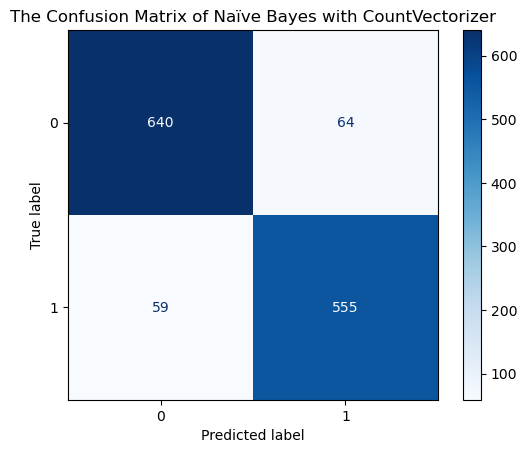

In [38]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe, param_grid=pipe_params, model_name="Naïve Bayes", transformer_name="CountVectorizer")

## Naïve Bayes Algorithm with TfidVectorizer

In [ ]:
# redifine training and testing split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [39]:
# describe pipeline with multinomial Naïve Bayes algorithm with tfidvectorizer transformer
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [40]:
# get to know pipeline params
pipe_tvec.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nb': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [41]:
# set pipeline params by tvec
pipe_tvec_params = {
    'tvec__tokenizer': [None, stem_words],
    'tvec__max_features': [5_000, 10_000, 20_000, 30_000],
    'tvec__min_df': [2, 3],
    'tvec__max_df': [.9, .95],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

===================== Summary of Naïve Bayes Model with TfidVectorizer Transformer Evaluation =====================
======== The Best Params =========
{'tvec__max_df': 0.9, 'tvec__max_features': 5000, 'tvec__min_df': 2, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': 'english', 'tvec__tokenizer': None}

========= The Best Score =========
0.8830930243722896

========== Train Score ===========
0.9433198380566802

=========== Test Score ===========
0.9059180576631259


C:\Users\sarvin.farhad\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


======= Evaluation Metrics =======
Accuracy  ---------- 0.9059180576631259
Precision  --------- 0.9209621993127147
Sensitivity  ------- 0.8729641693811075
Specifity  --------- 0.9346590909090909


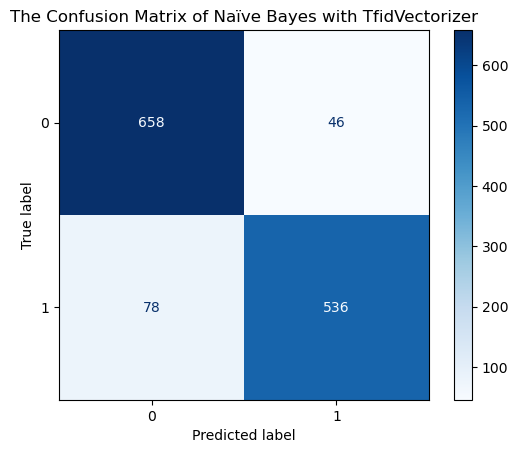

In [42]:
# Get the result of the model with defined parameters in GreadSearch
gridsearching(estimator=pipe_tvec, param_grid=pipe_tvec_params, model_name="Naïve Bayes", transformer_name="TfidVectorizer")